In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

## Question 3

In [2]:
csv_name = 'USRiskFreeRatesWeekly.csv'
rates = pd.read_csv(csv_name)
rates['DATE'] = pd.to_datetime(rates.DATE).dt.date
rates = rates.set_index('DATE')

def rates_pca(rates: pd.DataFrame, start_date: dt.date = None, end_date: dt.date = None) -> tuple:
    """
    This function takes in a pandas DataFrame of rates data and performs PCA
    analysis on the whole frame or a given subset.

    The code returns a DataFrame of factor loadings as well as a data frame of the principal compoents
    """
    # first compute the rate of change of the interest rates
    rates_chg = rates.pct_change().dropna(thresh=rates.shape[1])

    if start_date:
        rates_chg = rates_chg.loc[start_date:]
        
    if end_date:
        rates_chg = rates_chg.loc[:end_date]
        
    print(f'start: {rates_chg.index.min()}')
    print(f'end: {rates_chg.index.max()}')
    
    # performing PCA on raw changes
    # effectively working with their covariance matrix. 
    # This preserves the actual differences in variance across maturities.
    # dividing each maturity’s changes by its standard deviation, PCA is performed  on the correlation matrix, forcing every maturity to have unit variance. 
    rates_chg_norm = rates_chg #((rates_chg - rates_chg.mean(axis=0)) / rates_chg.std(ddof=1, axis=0))
    
    # calculate the correlation
    rates_cov = rates_chg_norm.cov()
    
    # calculate eigen decomp
    delta, gamma = np.linalg.eig(rates_cov)
    idx_sorted = np.argsort(delta)[::-1]  # descending
    delta = delta[idx_sorted]             # reorder eigenvalues
    gamma = gamma[:, idx_sorted]          # reorder eigenvectors    
    
    # (i) check that the original correlation matrix can be reconstructe by the spectral decomposition components
    precision = 12
    assert (rates_cov.values.round(precision) == (gamma @ np.diag(delta) @ gamma.T).round(precision)).all()

    # (ii) calculate the principal components
    P = rates_chg_norm @ gamma
    
    f_loadings = pd.DataFrame(gamma.T)
    return f_loadings, pd.DataFrame(np.diag(delta)), P

start: 2001-08-10
end: 2010-02-05
start: 2007-01-05
end: 2007-12-28
start: 2008-01-04
end: 2008-12-26
start: 2009-01-02
end: 2009-12-25


<Axes: title={'center': 'Rates PCA Variance Explained'}>

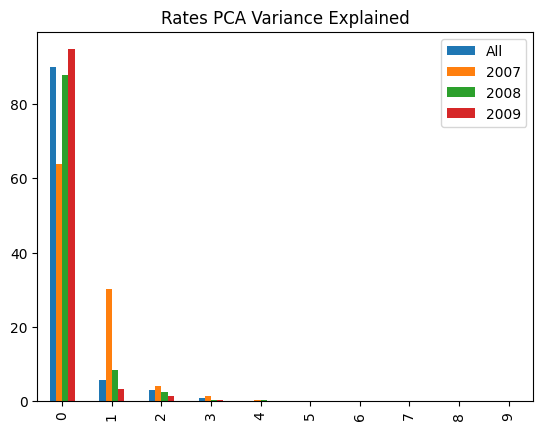

In [3]:
# run PCA code on the different time period
loadings_all, cov_vall, P_all = rates_pca(rates)
loadings_2007, cov_2007, P_2007 = rates_pca(rates, start_date=dt.date(2007, 1, 1), end_date=dt.date(2007, 12, 31))
loadings_2008, cov_2008, P_2008 = rates_pca(rates, start_date=dt.date(2008, 1, 1), end_date=dt.date(2008, 12, 31))
loadings_2009, cov_2009, P_2009 = rates_pca(rates, start_date=dt.date(2009, 1, 1), end_date=dt.date(2009, 12, 31))

# plot the percentage of variance explained side by side for comparison
(P_all.var() / P_all.var().sum()).rename('All').to_frame().join(
(P_2007.var() / P_2007.var().sum()).rename('2007')).join(
    (P_2008.var() / P_2008.var().sum()).rename('2008')
).join(
    (P_2009.var() / P_2009.var().sum()).rename('2009')
).mul(100).plot(kind='bar', title='Rates PCA Variance Explained')

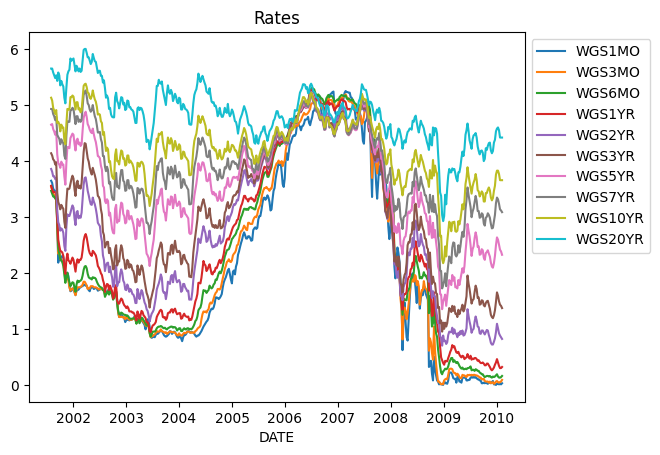

In [4]:
ax = rates.plot(kind='line', title='Rates')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

2007 - 2009 were turbulent times in the financial markets. Looking at the plot above you can see how the short term yields spiked leading to a flat-to-inverted yield curve. Intuitively, you would expect some movement in the risk factors. In 2007 the percentage of variance explained by the 2nd factor (slope of curve) spikes at the expense of the first factor, level of curve. Short-term Treasury yields experienced substantial volatility as the Federal Reserve aggressively cut the federal funds rate to near-zero levels in an effort to stimulate the economy and stabilize financial markets. The differences in the variance contributions are still more muted that I would have expected.

## Question 4


### 4.1 First calculate value of the portfolio
The present value of each bond is $ PV = \frac{F}{(1+r)^n}$. We can add them up for total portfolio value.

In [5]:
date = dt.date(2010, 1, 29)
rates /= 100
p = pd.DataFrame({
    'WGS1YR': 1e6 / (1 + rates.loc[:, 'WGS1YR'])**1,
    'WGS10YR': 1e6 / (1 + rates.loc[:, 'WGS10YR'])**1,
    'WGS20YR': 1e6 / (1 + rates.loc[:, 'WGS20YR'])**1,
})
p_val = p.sum(axis=1)

##### Value of Positions:

In [6]:
p.loc[date].round(2)

WGS1YR     996909.58
WGS10YR    964692.26
WGS20YR    957670.94
Name: 2010-01-29, dtype: float64

##### Total Portfolio Value:

In [7]:
print(f"Current Portfolio Value = {p_val.loc[date]:,.2f} USD")

Current Portfolio Value = 2,919,272.79 USD


### 4.2 VaR and CVaR using PCA results
Use just the first three principal components and assume that they have a multi-variate normal distribution with a diagonal variance-covariance matrix whose entries are given by the first three eigenvalues.

We are using the portfolio weights, factor loadings, and the factor variance-covariance matrix so calculate the estimated portfolio variance. Using the variance we can make use of the normal distribution assumptions to calculate the quantiles.

In [8]:
# Helper functions to calculate VaR and CVaR (ES)
def calc_var_norm(mu, sigma, alpha):
    var = mu + sigma * stats.norm.ppf(q=alpha)
    return var

def calc_es_norm(mu, sigma, alpha):
    es = mu + sigma * stats.norm.pdf(stats.norm.ppf(q=alpha)) / (1 - alpha)
    return es


In [9]:
# calculate the portfolio weights and reindex to align with the overall data
p_c = p.loc[date]
wts = p_c / p_c.sum()
wts = wts.reindex(rates.columns).fillna(0)

# extract the relevant loadings and covariacne components
l = loadings_2009.loc[:, 0:2]
l.index = rates.columns
cov = cov_2009.loc[0:2, 0:2]

# given the portfolio weights, its factor loadings, 
# and the factor covariance structure calculate the portfolio variance
p_var = (wts @ l) @ cov @ (wts @ l)
# calculate portfolio standard deviation
p_std = np.sqrt(p_var)

##### Calculate VaR/CVaR usig the portfolio variance and zero mean assumptions

In [10]:
var_res = pd.DataFrame(columns=['VaR', 'CVaR'])
var_res.index.name = 'Alpha'

In [11]:
alpha = 0.95
var = calc_var_norm(mu=0, sigma=p_std, alpha=alpha) * p_val.loc[date]
var_res.loc[alpha, 'VaR'] = var

es = calc_es_norm(mu=0, sigma=p_std, alpha=alpha) * p_val.loc[date]
var_res.loc[alpha, 'CVaR'] = es

alpha = 0.99
var = calc_var_norm(mu=0, sigma=p_std, alpha=alpha) * p_val.loc[date]
var_res.loc[alpha, 'VaR'] = var

es = calc_es_norm(mu=0, sigma=p_std, alpha=alpha) * p_val.loc[date]
var_res.loc[alpha, 'CVaR'] = es

In [12]:
df_styled = var_res.style.format({
    'VaR': '${:,.2f}',
    'CVaR': '${:,.2f}',
})
df_styled

,VaR,CVaR
Alpha,,
0.950000,"$173,908.30","$218,088.02"
0.990000,"$245,961.83","$281,789.74"


### 4.3 Use 2007-2009 data to calculate VaR and CVaR
We can use historical data to estimate the distributions of the rates. We can then take random draws from a multi-variate distribution. From these draws we can calculate the portfolio values and then find out the difference between the current value and the value from the simulated rates. Using percentiles we can then calculate the VaR and CVaR values. Making the assumption that it's a normal distribution here, the professor did not confirm nor deny that other assumptions should be made.

The VaR and CVaR values are printed after the code.

In [13]:
sd = dt.date(2007, 1, 1)
ed = dt.date(2009, 12, 31)

# Bond face values
FACE_VALUE_1Y = 1e6
FACE_VALUE_10Y = 1e6
FACE_VALUE_20Y = 1e6

# Mean yields in the future (assumption)
mu = rates.loc[sd:ed, ['WGS1YR', 'WGS10YR', 'WGS20YR']].mean()

# Standard deviations of yields (assumption)
sigma = rates.loc[sd:ed, ['WGS1YR', 'WGS10YR', 'WGS20YR']].std(ddof=1)

# For demonstration, assume zero correlation
# => Covariance matrix is diagonal
cov_matrix = rates.loc[sd:ed, ['WGS1YR', 'WGS10YR', 'WGS20YR']].cov()

# Number of Monte Carlo simulations
M = 100_000  # e.g., 100k draws

# Confidence levels for VaR/CVaR
alpha_levels = [0.95, 0.99]

def zero_coupon_bond_price(face_value, yield_, years_to_maturity):
    """
    Price of a zero-coupon bond with simple annual compounding.
    """
    return face_value / ((1 + yield_) ** years_to_maturity)

V0 = p_val.loc[date]

# -------------------------------
# 3. Monte Carlo Simulation
# -------------------------------
# Draw yields from a multivariate normal distribution
simulated_yields = np.random.multivariate_normal(mu, cov_matrix, size=M)

# Compute portfolio value in each scenario
simulated_values = np.zeros(M)
for i in range(M):
    y1, y10, y20 = simulated_yields[i]
    # Bond prices in scenario i
    p1 = zero_coupon_bond_price(FACE_VALUE_1Y, y1, 1)
    p10 = zero_coupon_bond_price(FACE_VALUE_10Y, y10, 10)
    p20 = zero_coupon_bond_price(FACE_VALUE_20Y, y20, 20)
    # Portfolio value
    simulated_values[i] = p1 + p10 + p20

# -------------------------------
# 4. Compute Losses
# -------------------------------
# Define loss as negative of the change in value
# Loss > 0 means the portfolio value has decreased.
losses = -(simulated_values - V0)  # L^m = -(V^m - V0)

# -------------------------------
# 5. Calculate VaR and CVaR
# -------------------------------
def empirical_var_cvar(loss_array, alpha):
    """
    Return (VaR_alpha, CVaR_alpha) for given alpha using empirical distribution.
    """
    sorted_losses = np.sort(loss_array)  # ascending order
    # Index at alpha quantile
    idx = int(np.ceil(alpha * len(sorted_losses))) - 1
    var_alpha = sorted_losses[idx]  # VaR is the loss at the alpha quantile

    # CVaR is average of losses beyond VaR
    losses_beyond_var = sorted_losses[idx:]
    cvar_alpha = losses_beyond_var.mean()
    return var_alpha, cvar_alpha

results = []
for alpha in alpha_levels:
    var_alpha, cvar_alpha = empirical_var_cvar(losses, alpha)
    results.append({
        'Alpha': alpha,
        'VaR': var_alpha,
        'CVaR': cvar_alpha
    })

In [14]:
df_results = pd.DataFrame(results)
df_styled = df_results.set_index('Alpha').style.format({
    'VaR': '${:,.2f}',
    'CVaR': '${:,.2f}',
})
df_styled

,VaR,CVaR
Alpha,,
0.950000,"$989,698.28","$1,024,498.89"
0.990000,"$1,046,275.07","$1,073,575.57"
